In [30]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
# from torchinfo import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [31]:
# 数据准备
def normalize_data(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val), min_val, max_val





# 定义模型
# 定义新模型
class ODModel(nn.Module):
    def __init__(self, N):
        super(ODModel, self).__init__()
        
        self.N = N  # 区域数
        n1 = 128    # 隐藏层神经元1
        n2 = 64     # 隐藏层神经元2
        
        # 每个区域可学习的权重 --> shape [N, 3]
        self.weights = nn.Parameter(torch.randn(N, 3))
        
        # MLP层 input [B,N] --> output [B,N*N]
        self.mlp = nn.Sequential(
            nn.Linear(N, n1),
            nn.ReLU(),
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Linear(n2, N * N)
        )
    
    def forward(self, x):
        '''
        前向传播
        :param x: Batch输入 --> [B,N,4]
        :return: Batch输出  --> [B,N,N]
        '''
        
        batch_size, N, _ = x.shape  # [B,N,4]

        x_speed= x[:, :, 0]  # 提取Speed [B,N,1]
        x_temp_freq_rand= x[:, :, 1:]  # 提取三个ΔX输入 [B,N,3]
        
        # 等式计算 Production [B, N] = speed[B,N] + sum([B,N,3] * [1,N,3]) = speed[B,N]+sum([B,N,3]) = [B,N]
        weighted_sum = x_speed + torch.sum(x_temp_freq_rand * self.weights.unsqueeze(0), dim=2)  

        # 输入到 MLP 网络中
        od_matrix_flat = self.mlp(weighted_sum)  # [B,N] --> [B, N * N]
        # reshape 最终输出
        od_matrix = od_matrix_flat.view(batch_size, N, N)  # [B, N, N]

        return od_matrix
    
    



# 测试

In [55]:
import numpy as np

# 生成 speed 数组，形状为 [2, 2]
speed = np.random.randint(0, 3, size=(2, 2))

# 生成 Δx 数组，形状为 [2, 2, 3]
delta_x = np.random.randint(0, 3, size=(2, 2, 3))

# 生成 weight 数组，形状为 [2, 3]
weight = np.random.randint(0, 2, size=(2, 3))


print("speed:")
print(speed)
print("\nΔx:")
print(delta_x)
print("\nweight:")
print(weight)
print("相乘结果")
print(delta_x *np.expand_dims(weight, axis=0))
print("求和结果")
print(np.sum(delta_x *np.expand_dims(weight, axis=0), axis=2))

production = speed + np.sum(delta_x *np.expand_dims(weight, axis=0), axis=2)
print(f"出发总量shape{production.shape}\n data:{production}")

speed:
[[0 0]
 [0 1]]

Δx:
[[[2 2 2]
  [1 1 0]]

 [[1 0 1]
  [0 1 2]]]

weight:
[[0 1 1]
 [0 1 0]]
相乘结果
[[[0 2 2]
  [0 1 0]]

 [[0 0 1]
  [0 1 0]]]
求和结果
出发总量shape(2, 2)
 data:[[4 1]
 [1 2]]


In [50]:
# 保存日志文件
log_filename = f"log/training_log_25.1.14版本_{time.strftime('%Y%m%d_%H%M%S')}.log"
with open(log_filename, 'w') as log_file:
    log_file.write("Epoch, Train Loss, Validation Loss\n")

# 训练过程
def train_model(model, train_loader, val_loader, epochs=100, patience=10,learning_rate=0.001, load=0):


    if load == 1 :
        # model.load_state_dict(torch.load('ckpt/best_model_feature4_25.1.14数据集版本_8.4087_1.3267.pth'))
        model.load_state_dict(torch.load('ckpt/best_model_feature4_25.1.14数据集版本.pth'))
        print(f"best model loaded")



    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 学习率调度器
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    patience_counter = 0
    N = 110


    # 训练过程
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 计算训练集的平均损失
        train_loss /= len(train_loader)

        # 验证过程
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # 计算验证集的平均损失
        val_loss /= len(val_loader)

        # LR调度器
        # scheduler.step(val_loss)

        # 保存每一轮的损失，并打印
        with open(log_filename, 'a') as log_file:
            log_file.write(f"{epoch + 1}, {train_loss:.4f}, {val_loss:.4f}\n")

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        # ({optimizer.param_groups[0]['lr']:.6f})

        # 提前停止机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), "ckpt/best_model_feature4_25.1.14数据集版本.pth")
            print(f"best saved at epoch{epoch + 1},best：{best_val_loss:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # 绘制训练过程中的损失曲线
    with open(log_filename, 'r') as log_file:
        epochs_list, train_loss_list, val_loss_list = [], [], []
        for line in log_file.readlines()[1:]:
            epoch, train_loss, val_loss = line.strip().split(", ")
            epochs_list.append(int(epoch))
            train_loss_list.append(float(train_loss))
            val_loss_list.append(float(val_loss))

    plt.plot(epochs_list, train_loss_list, label='Train Loss')
    plt.plot(epochs_list, val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'train and validation loss with lr={learning_rate}')
    plt.savefig("loss_curve.png")
    plt.show()





In [36]:
def calculate_rmse_mae(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(predictions - targets))
    return rmse.item(), mae.item()

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 设置所有GPU的随机种子




# 加载数据
def load_data():

    set_seed(42)

    # 加载数据
    data = np.load('data/武汉速度数据集_1KM_110区域_25.1.14.npy')  # 形状 [T, N, 2]
    speed = data[:, :, 0]  # 平均速度 [T, N]

    od = np.load('data/武汉OD数据集_1KM_110区域_过滤cnt_对角线0_25.1.14.npy')  # 形状 [T, N, N]

    # 设置均值和标准差
    mean = 0.05
    std_dev = 0.01
    # 获取数据长度 T
    T, N = speed.shape

    # 生成T组高斯分布数据
    x_random = np.random.normal(loc=mean, scale=std_dev, size=(T, N))

    # 将数据裁剪到0到1之间
    x_random = np.clip(x_random, 0, 0.1)

    # 按顺序划分数据
    train_size = int(T * 0.6)
    val_size = int(T * 0.2)

    # 顺序划分索引
    train_indices = np.arange(0, train_size)
    val_indices = np.arange(train_size, train_size + val_size)
    test_indices = np.arange(train_size + val_size, T)

    # 按索引划分数据
    speed_train, speed_val, speed_test = speed[train_indices], speed[val_indices], speed[test_indices]
    od_train, od_val, od_test = od[train_indices], od[val_indices], od[test_indices]
    x_random_train, x_random_val, x_random_test = x_random[train_indices], x_random[val_indices], x_random[test_indices]

    # 输出划分后的数据形状
    print("6:2:2顺序划分的训练集Speed", speed_train.shape, "OD", od_train.shape)
    print("6:2:2顺序划分的验证集Speed", speed_val.shape, "OD", od_val.shape)
    print("6:2:2顺序划分的测试集Speed", speed_test.shape, "OD", od_test.shape)


    # 在训练集上计算 OD 出发总量
    od_train_departures = np.sum(od_train, axis=-1)  # 形状 [T_train, N]

    # 计算每个区域在 T_train 时间步的平均速度和平均出发总量
    mean_speed = np.mean(speed_train, axis=0)  # 每个区域的平均速度 [N,]
    mean_departures = np.mean(od_train_departures, axis=0)  # 每个区域的平均出发总量 [N,]

    # 计算平均速度和平均出发总量的差值
    temporal = mean_departures - mean_speed  # [N,]

    # 输出结果
    # print("temporal 变量形状：", temporal.shape)

    # 将 temporal 变量扩展到与输入数据时间维度匹配
    temporal_expanded_train = np.tile(temporal, (speed_train.shape[0], 1))  # [T_train, N]
    temporal_expanded_val = np.tile(temporal, (speed_val.shape[0], 1))  # [T_val, N]
    temporal_expanded_test = np.tile(temporal, (speed_test.shape[0], 1))  # [T_test, N]

    # freq
    speed_freq = np.load('data/速度的周期状态_对应25.1.14的速度数据集.npy')  # 形状 [N,]
    od_freq = np.load('data/OD的周期状态_对应25.1.14的OD数据集.npy')  # 形状 [N,]
    # print(speed_freq.shape)
    # print(od_freq.shape)
    freq = od_freq - speed_freq

    freq_expanded_train = np.tile(freq, (speed_train.shape[0], 1))  # [T_train, N]
    freq_expanded_val = np.tile(freq, (speed_val.shape[0], 1))  # [T_val, N]
    freq_expanded_test = np.tile(freq, (speed_test.shape[0], 1))  # [T_test, N]

    # 添加到训练集、验证集和测试集
    x_train = np.stack([speed_train, temporal_expanded_train, freq_expanded_train, x_random_train],
                       axis=-1)  # [T_train, N, 3]
    x_val = np.stack([speed_val, temporal_expanded_val, freq_expanded_val, x_random_val], axis=-1)  # [T_val, N, 3]
    x_test = np.stack([speed_test, temporal_expanded_test, freq_expanded_test, x_random_test],
                      axis=-1)  # [T_test, N, 3]

    # 打印结果形状
    print("特征处理后的训练集 shape:", x_train.shape, "OD形状", od_train.shape)
    print("特征处理后的验证集 shape:", x_val.shape, "OD形状", od_val.shape)
    print("特征处理后的测试集 shape:", x_test.shape, "OD形状", od_test.shape)



    # 硬编码归一化
    # scaler = MinMaxScaler()
    # train_data = scaler.fit_transform(x_train.reshape(-1, 4)).reshape(100, 110, 4)
    # val_data = scaler.transform(x_val.reshape(-1, 4)).reshape(33, 110, 4)
    # test_data = scaler.transform(x_test.reshape(-1, 4)).reshape(35, 110, 4)

    # 归一化
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(x_train.reshape(-1, 4)).reshape(x_train.shape)
    val_data = scaler.transform(x_val.reshape(-1, 4)).reshape(x_val.shape)
    test_data = scaler.transform(x_test.reshape(-1, 4)).reshape(x_test.shape)


    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    train_target = torch.tensor(od_train, dtype=torch.float32)
    val_target = torch.tensor(od_val, dtype=torch.float32)
    test_target = torch.tensor(od_test, dtype=torch.float32)

    # 打印结果形状
    print("归一化后的训练集 shape:", train_data.shape, "OD形状", train_target.shape)
    print("归一化后的验证集 shape:", val_data.shape, "OD形状",val_target.shape)
    print("归一化后的测试集 shape:", test_data.shape, "OD形状", test_target.shape)


    train_dataset = TensorDataset(train_data, train_target)
    val_dataset = TensorDataset(val_data, val_target)
    test_dataset = TensorDataset(test_data, test_target)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, val_loader, test_loader




In [37]:
# 测试
def test_model(model, test_loader,lr=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # model.load_state_dict(torch.load("ckpt/best_model_feature4_25.1.14数据集版本.pth"))
    model.load_state_dict(torch.load("ckpt/best_model_feature4_25.1.14数据集版本_6.8681_1.1940_lr_0.015.pth"))


    #打印结构
    # summary(model, input_size=(32, 110, 4))

    model.eval()
    test_loss = 0
    rmse_total = 0
    mae_total = 0
    criterion = nn.MSELoss()
    N= 110

    all_real_od = []
    all_pred_od = []

    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # 设置对角线掩码
            mask = torch.ones_like(targets)
            for i in range(N):
                mask[:, i, i] = 0  # 对角线上的元素设为 0

            print(f"输入:{inputs.shape},标签:{targets.shape}")

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # 计算 RMSE 和 MAE
            rmse, mae = calculate_rmse_mae(outputs * mask, targets)
            rmse_total += rmse
            mae_total += mae

            all_real_od.append(targets.cpu().numpy())
            all_pred_od.append(outputs.cpu().numpy())

    test_loss /= len(test_loader)
    rmse_total /= len(test_loader)
    mae_total /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f}")
    with open(log_filename, 'a') as log_file:
        log_file.write(f"Test RMSE: {rmse_total:.4f}, MAE: {mae_total:.4f}\n")
    torch.save(model.state_dict(), f"ckpt/best_model_feature4_25.1.14数据集版本_{rmse_total:.4f}_{mae_total:.4f}_lr_{lr}.pth")

    # 计算平均的OD矩阵
    # 设置不使用科学计数法
    np.set_printoptions(precision=2, suppress=True)
    all_real_od_t = np.concatenate(all_real_od, axis=0)
    all_pred_od_t = np.concatenate(all_pred_od, axis=0)
    all_real_od = np.mean(all_real_od_t, axis=0)
    all_pred_od = np.mean(all_pred_od_t, axis=0)



    print("-------------------不同时间步上---------------------")
    for i in range(0, all_real_od_t.shape[0], 4):
        print(f"-----第{i}个时间步的真实值------")
        print(np.round(all_real_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位
        print(f"-----第{i}个时间步的预测值-----")
        print(np.round(all_pred_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位
        print("\n")

        
        # 绘制真实 OD 热力图
        vmin = min(all_pred_od_t[i].min(), all_real_od_t[i].min())
        vmax = max(all_pred_od_t[i].max(), all_real_od_t[i].max())
        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 1)
        sns.heatmap(all_real_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
        plt.title(f"OD Matrix of step{i}", fontsize=14)
        plt.xlabel("Destination Zones")
        plt.ylabel("Origin Zones")

        # 绘制预测 OD 热力图
        plt.subplot(1, 2, 2)
        sns.heatmap(all_pred_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
        plt.title(f"Predicted OD Matrix of step{i}", fontsize=14)
        plt.xlabel("Destination Zones")
        plt.ylabel("Origin Zones")
        # 调整布局并显示
        plt.tight_layout()
        plt.show()

    print("-------------------平均时间步上---------------------")
    print(np.round(all_real_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位
    print("----------------------------------------------------")
    print(np.round(all_pred_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位

    vmin = min(all_pred_od.min(), all_real_od.min())
    vmax = max(all_pred_od.max(), all_real_od.max())
    # print(f"real max:{all_real_od.max()}, real min:{all_real_od.min()}")
    # print(f"pred max:{all_pred_od.max()}, pred min:{all_pred_od.min()}")
    # print(f"Max: {vmax:.4f}, Min: {vmin:.4f}")
    true_max = all_real_od_t.max()
    pred_max = all_pred_od_t.max()
    print(f"真实最大值{true_max},预测最大值，{pred_max}")



    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od, cmap="Blues", cbar=True,vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od, cmap="Blues", cbar=True,vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    # plt.show()

    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    # plt.show()




6:2:2顺序划分的训练集Speed (100, 110) OD (100, 110, 110)
6:2:2顺序划分的验证集Speed (33, 110) OD (33, 110, 110)
6:2:2顺序划分的测试集Speed (35, 110) OD (35, 110, 110)
特征处理后的训练集 shape: (100, 110, 4) OD形状 (100, 110, 110)
特征处理后的验证集 shape: (33, 110, 4) OD形状 (33, 110, 110)
特征处理后的测试集 shape: (35, 110, 4) OD形状 (35, 110, 110)
归一化后的训练集 shape: torch.Size([100, 110, 4]) OD形状 torch.Size([100, 110, 110])
归一化后的验证集 shape: torch.Size([33, 110, 4]) OD形状 torch.Size([33, 110, 110])
归一化后的测试集 shape: torch.Size([35, 110, 4]) OD形状 torch.Size([35, 110, 110])
Epoch [1/2000], Train Loss: 171.0735, Validation Loss: 188.8816
best saved at epoch1,best：188.8816
Epoch [2/2000], Train Loss: 136.0213, Validation Loss: 142.0947
best saved at epoch2,best：142.0947
Epoch [3/2000], Train Loss: 103.9984, Validation Loss: 117.4398
best saved at epoch3,best：117.4398
Epoch [4/2000], Train Loss: 91.4661, Validation Loss: 82.6526
best saved at epoch4,best：82.6526
Epoch [5/2000], Train Loss: 79.7835, Validation Loss: 80.9414
best saved at epoch5,best：80.

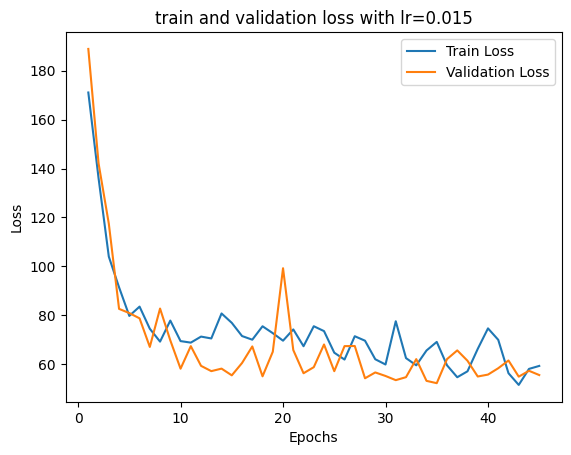

输入:torch.Size([32, 110, 4]),标签:torch.Size([32, 110, 110])
输入:torch.Size([3, 110, 4]),标签:torch.Size([3, 110, 110])
Test Loss: 51.9990
Test RMSE: 6.8681 Test MAE: 1.1940
-------------------不同时间步上---------------------
-----第0个时间步的真实值------
[[  0. 191.   0.  20.   3.   3.  44.  81.]
 [260.   0.   0.  15.   4.   6.  47.  18.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  9.  11.   3.   0.  28.  94.  83.  53.]
 [  7.   0.   0.  22.   0.  23.   7.  17.]
 [ 10.   3.   0.  30.  37.   0.  27.  37.]
 [ 40.  31.   3.  68.  19.  91.   0. 686.]
 [136.  68.   0. 164.  24.  85. 712.   0.]]
-----第0个时间步的预测值-----
[[ -0. 251.   1.  11.   6.   8.  28.  77.]
 [248.   0.   0.   7.   3.   3.  18.  32.]
 [  1.   1.  -0.   3.   1.  -1.   0.   2.]
 [ 12.   7.   0.   0.  72.  57.  59.  71.]
 [  5.   2.   1.  59.   0.  37.  11.  18.]
 [ 11.   5.   0.  46.  35.  -0.  67.  85.]
 [ 28.  15.  -1.  46.  10.  78.   0. 448.]
 [ 86.  33.   2.  75.  23.  80. 463.  -0.]]




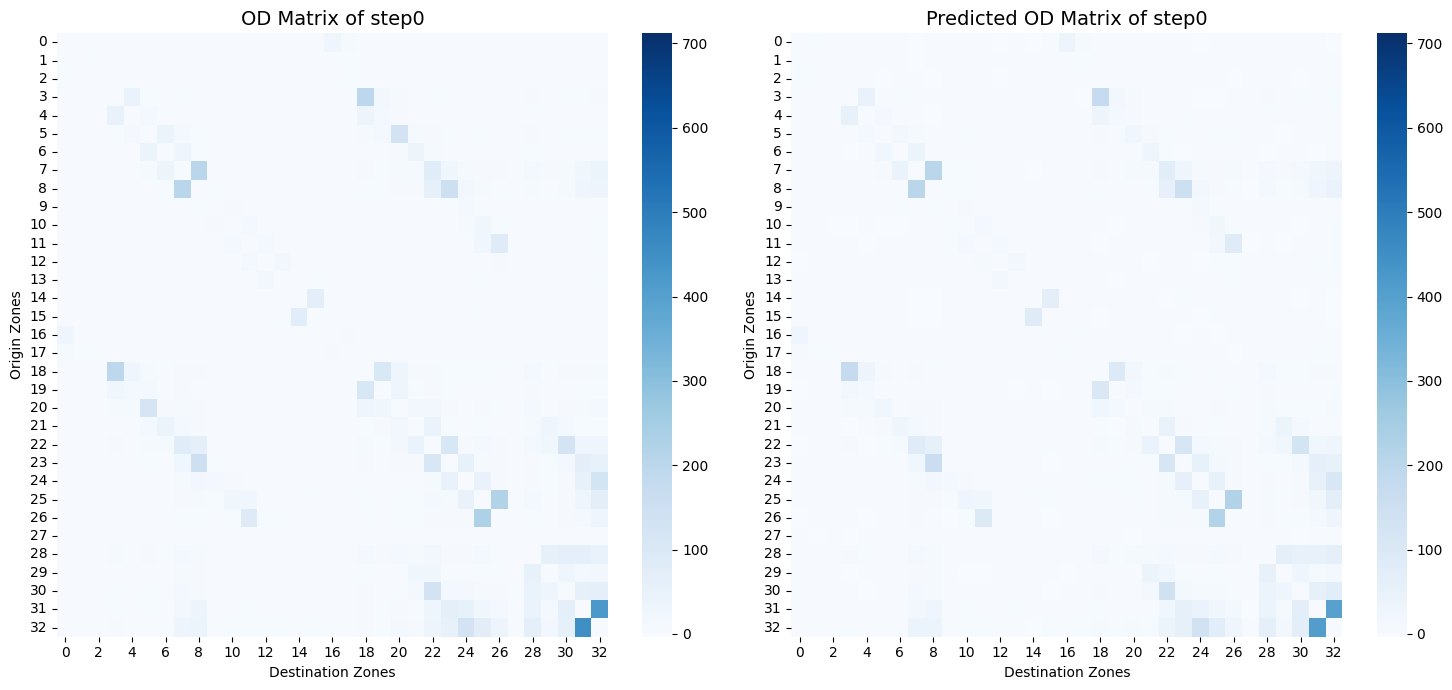

-----第4个时间步的真实值------
[[  0. 325.   4.  13.  10.  14.  49.  96.]
 [303.   0.   0.   7.   0.   0.  17.  43.]
 [  0.   0.   0.   0.   0.   4.   4.   0.]
 [ 21.   7.   0.   0.  30.  28.  94.  64.]
 [  3.   2.   0.  12.   0.  27.  18.  42.]
 [ 18.  13.   3.  27.  39.   0.  74.  84.]
 [ 57.  51.   0.  49.  22.  68.   0. 552.]
 [165.  73.   0.  89.  49. 130. 697.   0.]]
-----第4个时间步的预测值-----
[[ -0. 186.   1.   8.   4.   6.  21.  57.]
 [183.   0.   0.   5.   2.   3.  13.  24.]
 [  1.   1.  -0.   2.   0.  -1.   0.   2.]
 [  9.   5.   0.   0.  53.  42.  43.  53.]
 [  4.   2.   1.  44.   0.  27.   8.  13.]
 [  8.   4.   0.  34.  26.   0.  49.  63.]
 [ 21.  11.  -1.  34.   8.  57.   0. 331.]
 [ 64.  25.   1.  55.  17.  59. 343.  -0.]]




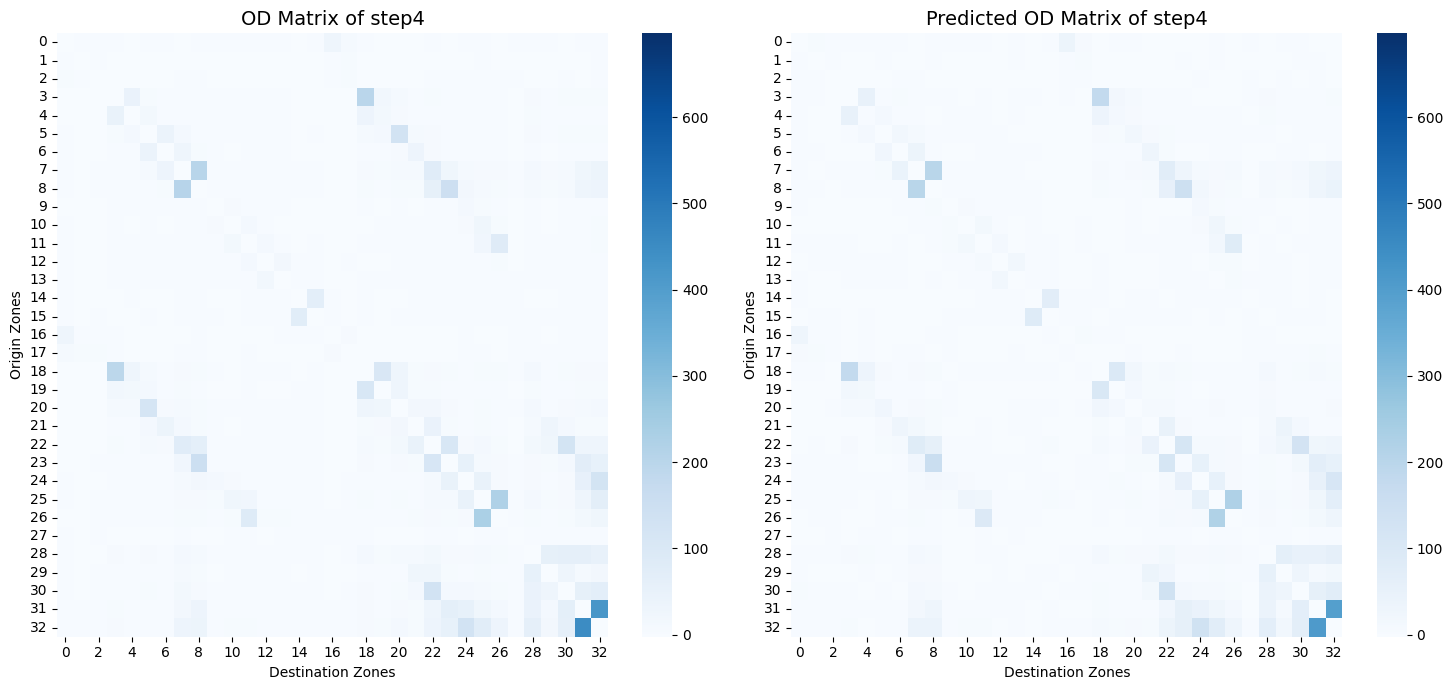

-----第8个时间步的真实值------
[[  0. 300.   0.   7.   7.   6.  74. 123.]
 [249.   0.   0.   7.   0.  13.  57.  80.]
 [  0.   3.   0.   0.   0.   0.   2.   0.]
 [  9.   0.   0.   0.   8.  59.  92.  30.]
 [  0.   0.   0.  23.   0.   8.   9.  19.]
 [  4.   1.   3.   6.  11.   0.  46.  32.]
 [ 21.  31.   1.  23.   1.  60.   0. 589.]
 [ 51.  14.   4.  24.   8.  46. 673.   0.]]
-----第8个时间步的预测值-----
[[ -0. 233.   1.  10.   5.   8.  26.  71.]
 [230.   0.   0.   6.   2.   3.  16.  30.]
 [  1.   1.  -0.   2.   1.  -1.   0.   2.]
 [ 11.   6.   0.   0.  67.  53.  54.  66.]
 [  5.   2.   1.  55.   0.  34.  11.  17.]
 [ 11.   5.   0.  43.  32.   0.  62.  79.]
 [ 26.  14.  -1.  42.  10.  72.   0. 415.]
 [ 80.  31.   2.  69.  21.  74. 429.  -0.]]




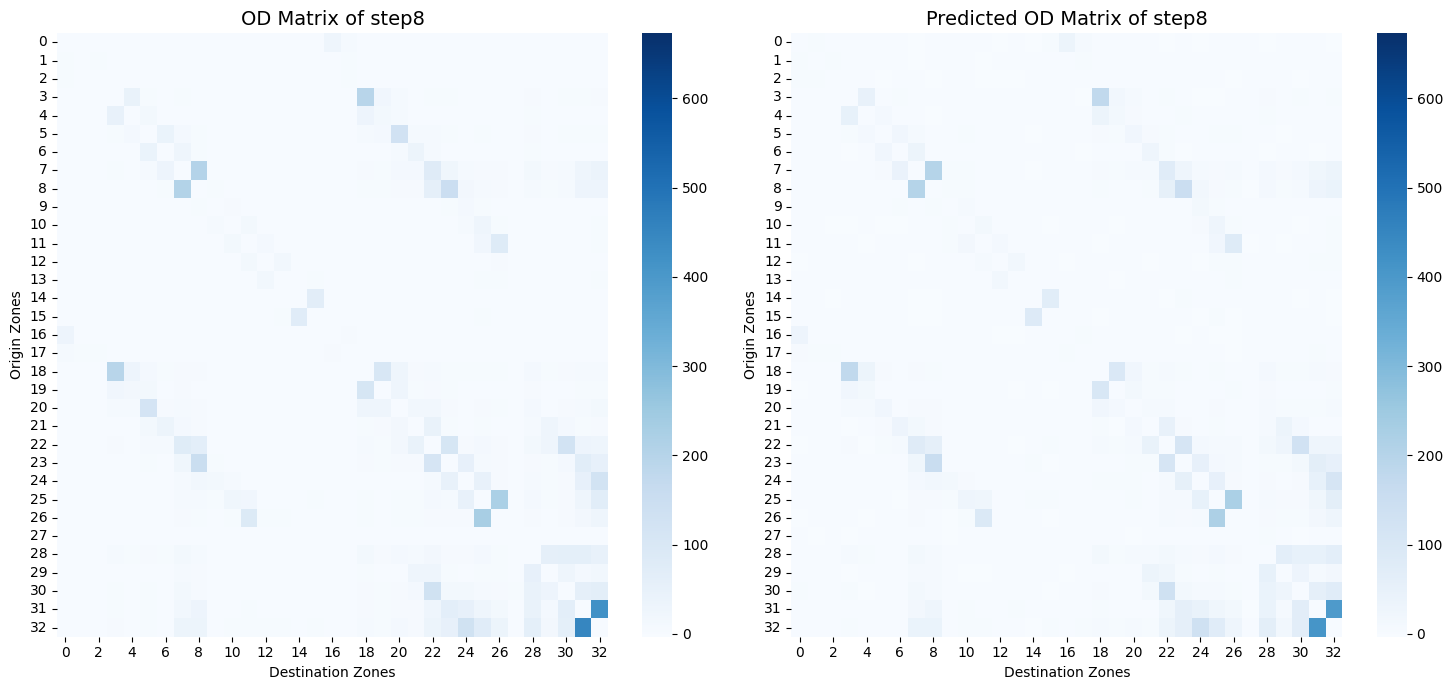

-----第12个时间步的真实值------
[[ 0. 28.  0.  0.  0.  0.  0.  7.]
 [61.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  2.  2.  0. 40.]
 [ 8.  3.  0.  0.  3.  0. 69.  0.]]
-----第12个时间步的预测值-----
[[ -0. 252.   1.  11.   6.   8.  28.  77.]
 [249.   0.   0.   7.   3.   3.  18.  32.]
 [  1.   1.  -0.   3.   1.  -1.   0.   2.]
 [ 12.   7.   0.   0.  72.  58.  59.  72.]
 [  5.   2.   1.  59.   0.  37.  11.  18.]
 [ 11.   5.   0.  46.  35.  -0.  67.  85.]
 [ 28.  15.  -1.  46.  10.  78.   0. 449.]
 [ 86.  33.   2.  75.  23.  80. 464.  -0.]]




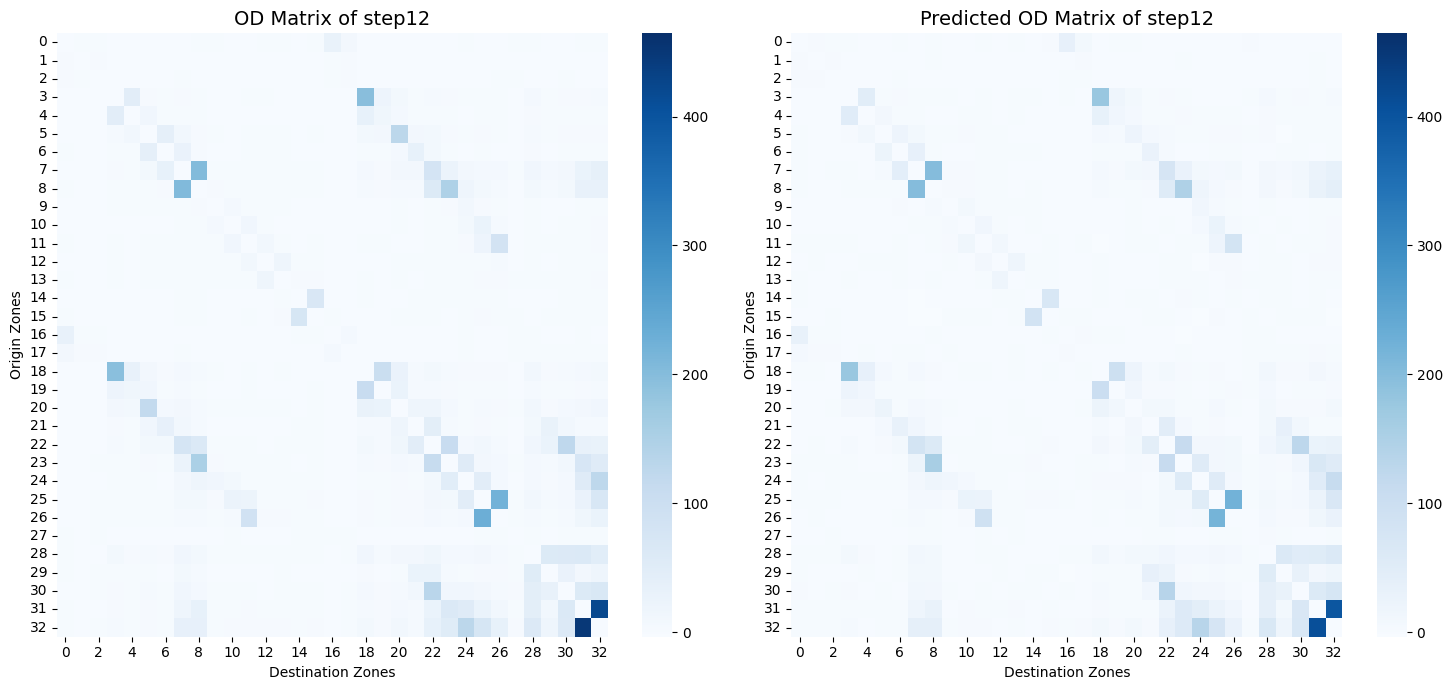

-----第16个时间步的真实值------
[[ 0. 39.  0.  0.  0.  0.  0. 12.]
 [45.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  2.  0.  1.  0.  4.  0.  0.]
 [ 3.  0.  0.  3.  0.  0.  7.  0.]
 [ 2.  0.  0.  0.  0.  1.  0.  8.]
 [ 3.  0.  0.  0.  0.  4. 28.  0.]]
-----第16个时间步的预测值-----
[[ -0. 269.   2.  11.   6.   9.  30.  82.]
 [265.   0.   0.   7.   3.   4.  19.  34.]
 [  1.   2.  -0.   3.   1.  -1.   0.   2.]
 [ 13.   7.   0.   0.  77.  61.  63.  76.]
 [  5.   2.   1.  63.   0.  39.  12.  19.]
 [ 12.   5.   0.  49.  37.  -0.  71.  91.]
 [ 30.  16.  -1.  49.  11.  83.   0. 478.]
 [ 92.  35.   2.  80.  24.  85. 495.  -0.]]




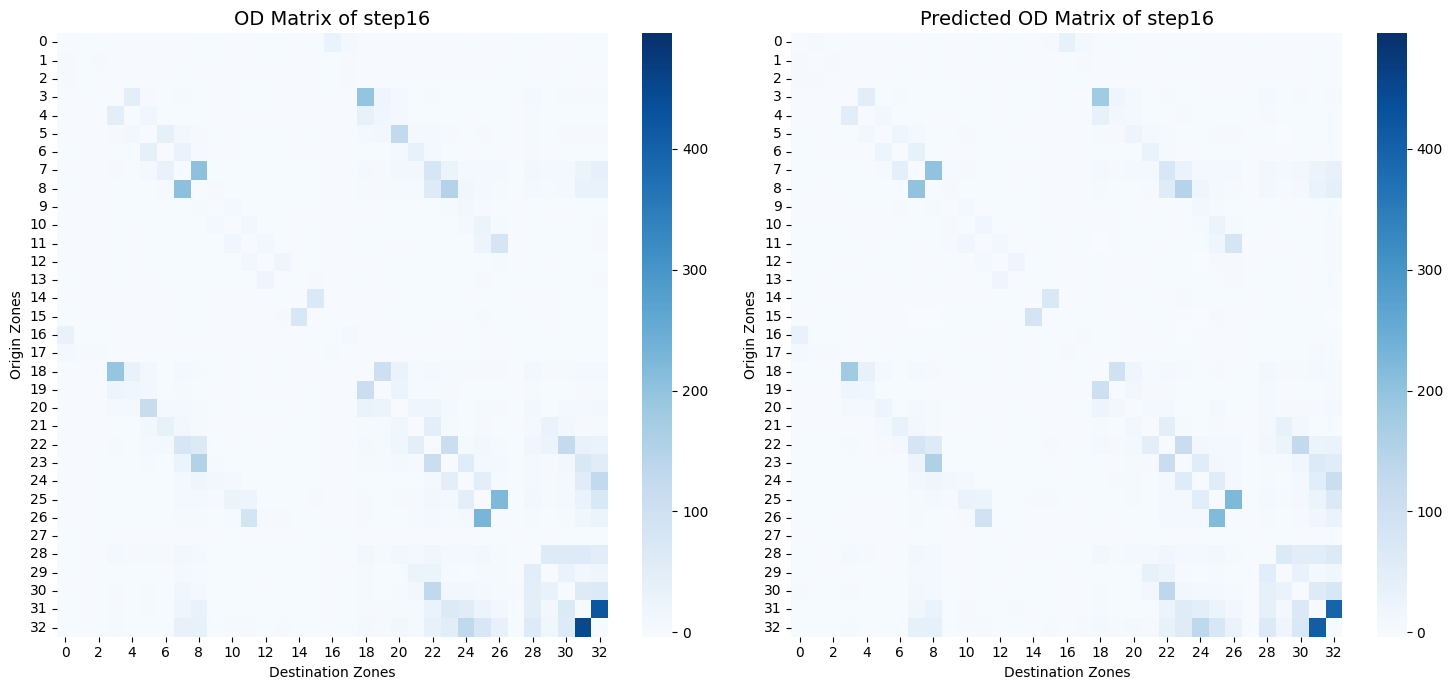

-----第20个时间步的真实值------
[[  0. 308.   3.  11.  11.   5.  20.  48.]
 [377.   0.   0.  23.   0.   9.  17.  23.]
 [  5.   0.   0.   2.   3.   5.   7.   4.]
 [ 35.   7.   0.   0. 189. 207.  97.  56.]
 [  9.   8.   0. 196.   0.  99.  25.  40.]
 [ 23.   6.   2. 154.  69.   0.  85.  76.]
 [ 38.  12.   0.  69.  17.  69.   0. 459.]
 [102.  41.   4. 114.  16.  51. 532.   0.]]
-----第20个时间步的预测值-----
[[ -0. 226.   1.   9.   5.   7.  25.  69.]
 [223.   0.   0.   6.   2.   3.  16.  29.]
 [  1.   1.  -0.   2.   1.  -1.   0.   2.]
 [ 11.   6.   0.   0.  65.  52.  53.  64.]
 [  4.   2.   1.  53.   0.  33.  10.  16.]
 [ 10.   5.   0.  41.  31.   0.  60.  76.]
 [ 25.  14.  -1.  41.   9.  70.   0. 403.]
 [ 78.  30.   2.  67.  20.  72. 417.  -0.]]




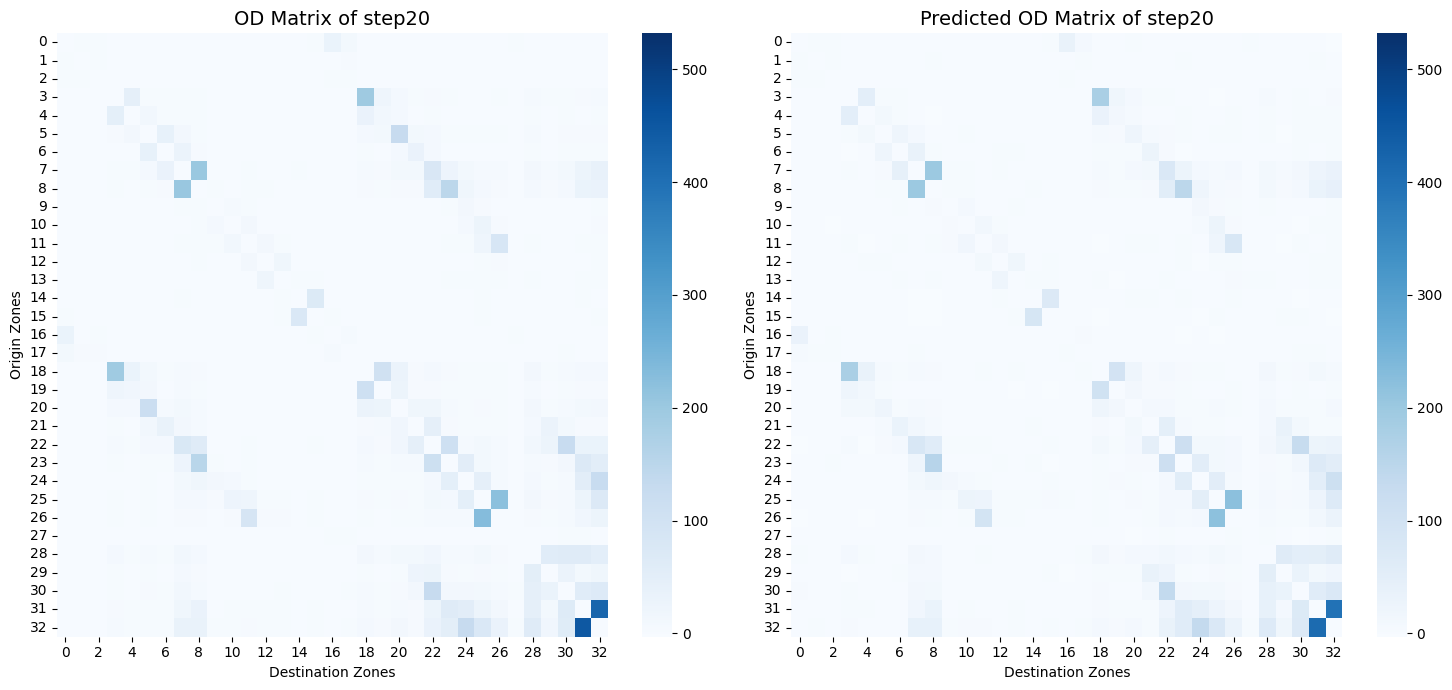

-----第24个时间步的真实值------
[[  0. 174.   0.   7.   3.   2.  16.  50.]
 [155.   0.   0.   3.   0.   3.   9.  24.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  3.   5.   0.   0.  66.  80. 124.  48.]
 [  3.   2.   5.  94.   0.  85.  10.  14.]
 [  7.   7.   0.  60.  65.   0.  52.  84.]
 [ 51.   2.   1. 109.  16.  66.   0. 533.]
 [ 71.  44.   0.  89.  12.  69. 584.   0.]]
-----第24个时间步的预测值-----
[[ -0. 258.   1.  11.   6.   8.  29.  79.]
 [254.   0.   0.   7.   3.   4.  18.  33.]
 [  1.   1.  -0.   3.   1.  -1.   0.   2.]
 [ 13.   7.   0.   0.  74.  59.  60.  73.]
 [  5.   2.   1.  61.   0.  37.  12.  19.]
 [ 12.   5.   0.  47.  35.  -0.  68.  87.]
 [ 29.  16.  -1.  47.  11.  79.   0. 459.]
 [ 88.  34.   2.  77.  23.  82. 475.  -0.]]




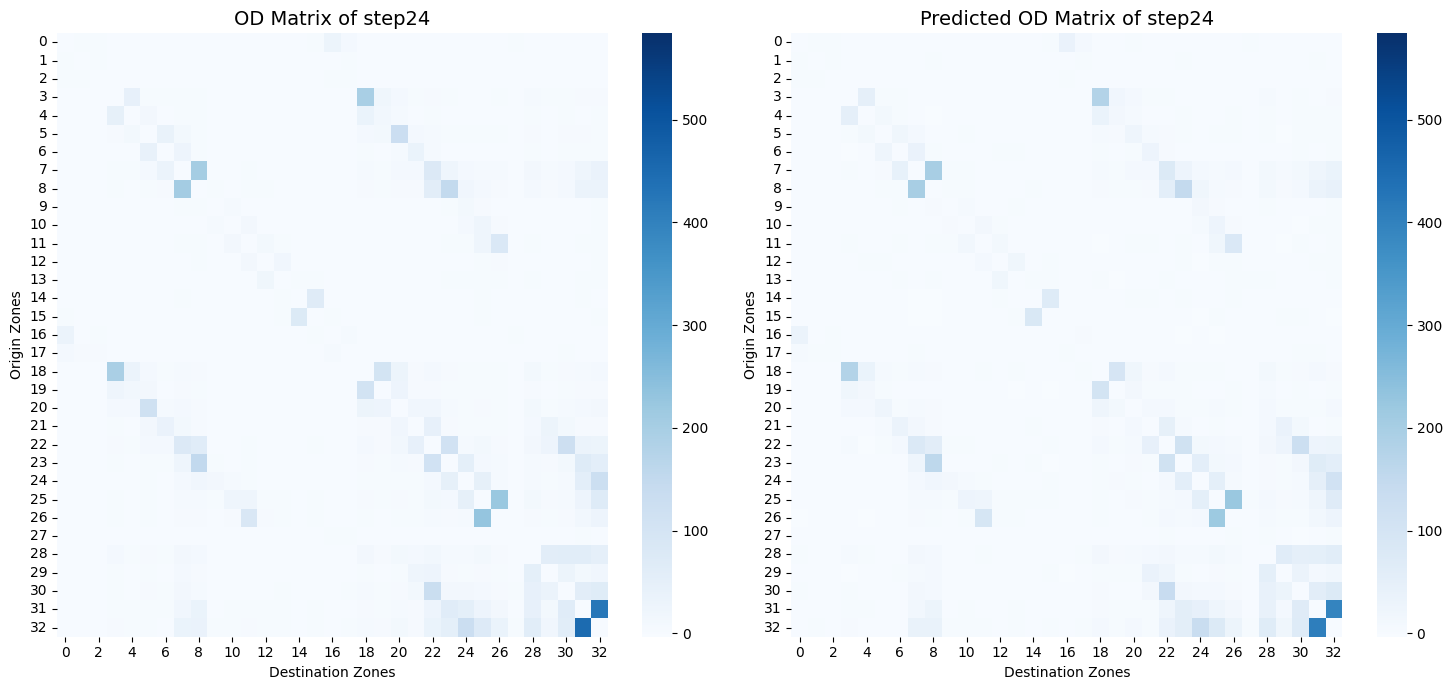

-----第28个时间步的真实值------
[[  0. 281.   3.  16.  17.  27.  24.  81.]
 [186.   0.   6.   9.   1.   5.  20.  36.]
 [  0.   3.   0.   0.   2.   1.   5.   5.]
 [  5.   4.   4.   0. 121. 110. 134.  62.]
 [  2.   2.   7.  71.   0.  72.  20.  25.]
 [ 34.  17.  17.  70. 138.   0. 136. 156.]
 [ 11.  17.  11. 118.  24. 108.   0. 568.]
 [ 72.  29.  14.  67.  82. 108. 486.   0.]]
-----第28个时间步的预测值-----
[[ -0. 212.   1.   9.   5.   7.  24.  65.]
 [209.   0.   0.   6.   2.   3.  15.  27.]
 [  1.   1.  -0.   2.   1.  -1.   0.   2.]
 [ 10.   6.   0.   0.  61.  48.  49.  60.]
 [  4.   2.   1.  50.   0.  31.  10.  15.]
 [ 10.   4.   0.  39.  29.   0.  56.  71.]
 [ 24.  13.  -1.  39.   9.  65.   0. 377.]
 [ 73.  28.   1.  63.  19.  67. 390.   0.]]




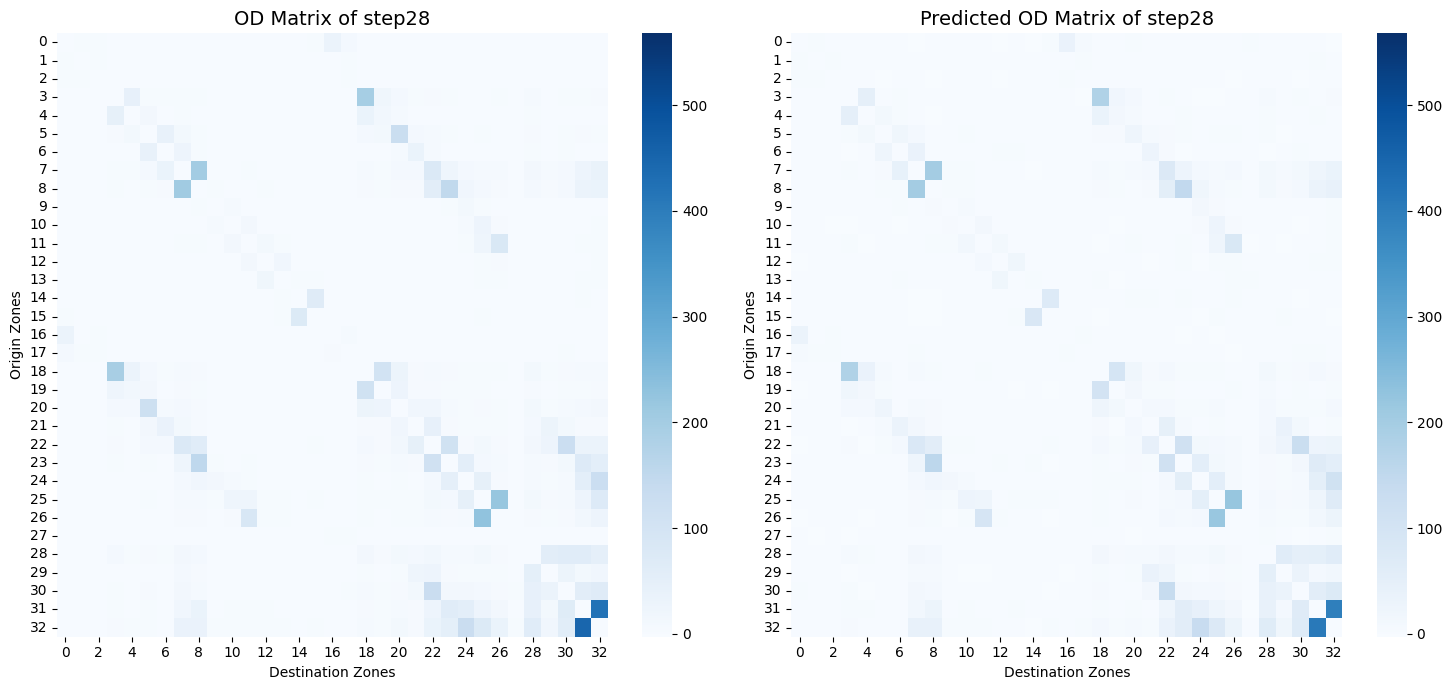

-----第32个时间步的真实值------
[[  0. 357.   0.  14.   9.   5.  27. 136.]
 [361.   0.   0.   0.   1.   4.  18.  66.]
 [  4.   0.   0.   0.   0.   0.   0.   0.]
 [ 22.   0.   0.   0.   8.  38.  39.  19.]
 [  3.   5.   0.  24.   0.  23.   8.  31.]
 [  4.   7.   0.  21.  14.   0.  52.  91.]
 [ 19.   0.   3.  13.   5.  90.   0. 480.]
 [ 52.  12.   0.  16.   7.  65. 437.   0.]]
-----第32个时间步的预测值-----
[[ -0. 248.   1.  10.   5.   8.  28.  76.]
 [244.   0.   0.   7.   3.   3.  17.  32.]
 [  1.   1.  -0.   2.   1.  -1.   0.   2.]
 [ 12.   7.   0.   0.  71.  56.  58.  70.]
 [  5.   2.   1.  58.   0.  36.  11.  18.]
 [ 11.   5.   0.  45.  34.  -0.  66.  84.]
 [ 28.  15.  -1.  45.  10.  76.   0. 441.]
 [ 85.  33.   2.  74.  22.  79. 456.  -0.]]




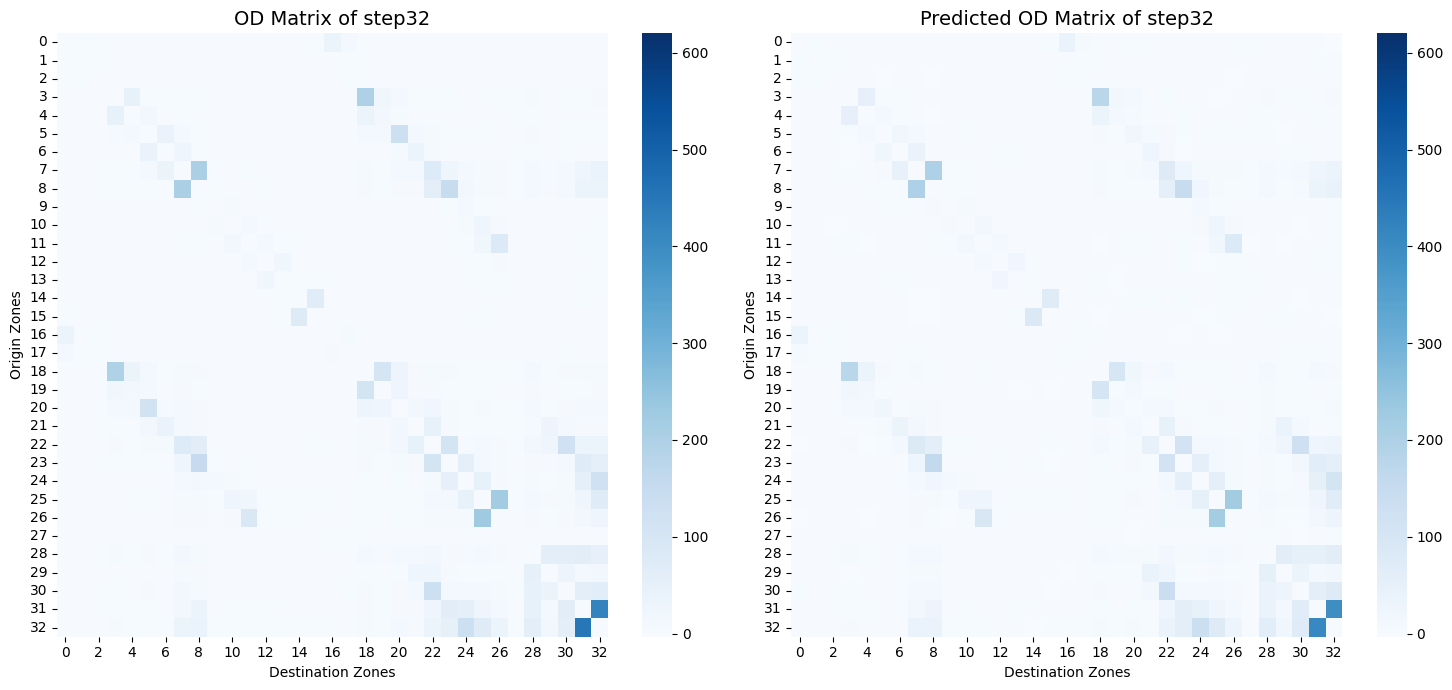

-------------------平均时间步上---------------------
[[  0 222   1  12   4   7  28  71]
 [230   0   1   5   2   6  16  27]
 [  1   1   0   1   0   1   2   1]
 [ 11   4   1   0  59  62  63  50]
 [  4   3   1  53   0  29  11  18]
 [ 10   5   2  46  32   0  59  66]
 [ 27  13   1  46  11  64   0 422]
 [ 74  34   2  62  18  61 450   0]]
----------------------------------------------------
[[  0 222   1   9   5   7  25  68]
 [219   0   0   6   2   3  16  29]
 [  1   1   0   2   1  -1   0   2]
 [ 11   6   0   0  64  51  52  63]
 [  4   2   1  52   0  32  10  16]
 [ 10   4   0  41  31   0  59  75]
 [ 25  14  -1  40   9  68   0 395]
 [ 76  29   2  66  20  71 409   0]]
真实最大值1173.0,预测最大值，527.6702270507812


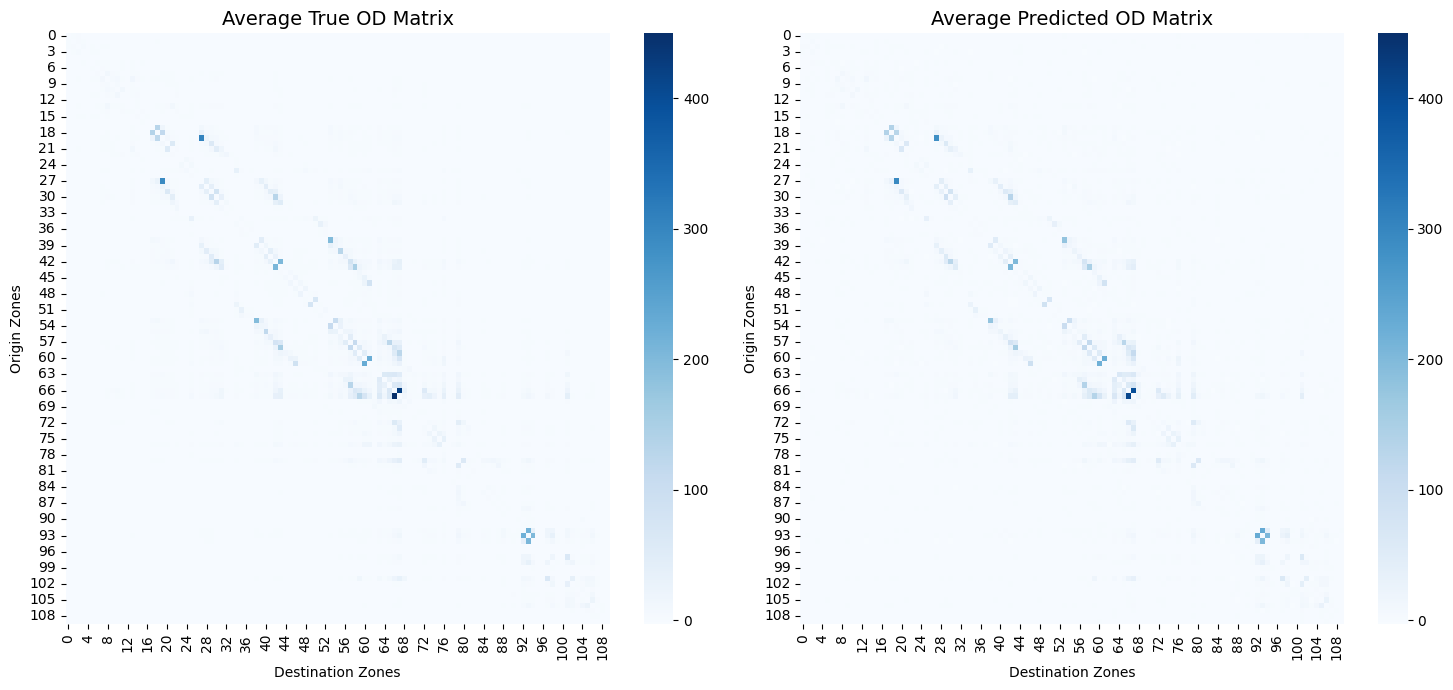

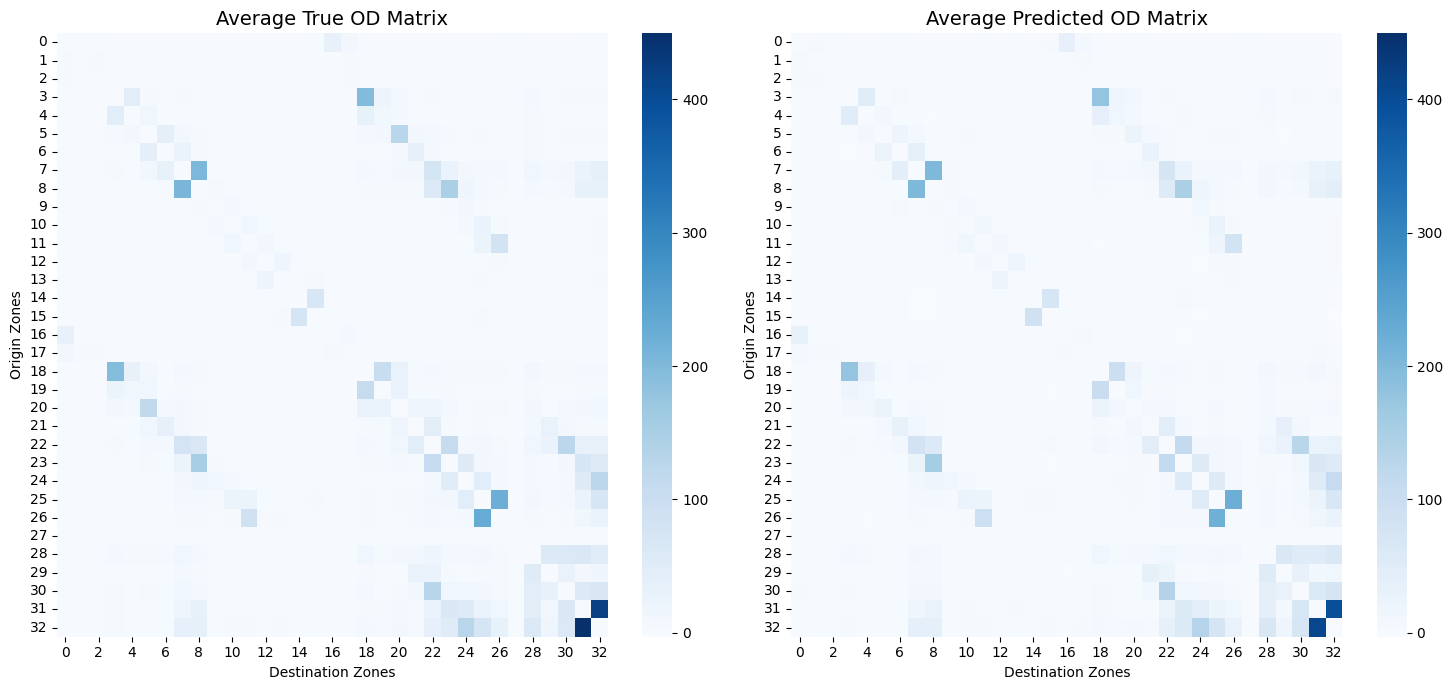

In [38]:
# 主程序
def main():
    train_loader, val_loader, test_loader = load_data()
    model = ODModel(N=110)  # N为区域数

    # # 定义不同的学习率
    # learning_rates = [0.5,0.4,0.2, 0.1, 0.05,0.01,0.005, 0.001, 0.0005,0.0001,0.00005,0.00001]

    lr = 0.015

    # 训练模型
    train_model(model, train_loader, val_loader, epochs=2000, patience=10, learning_rate=lr, load=0)

    # 测试模型
    test_model(model, test_loader, lr=lr)


if __name__ == "__main__":
    main()